## Code 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
import math
import re
import gc
import random
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rezka/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
inps = []
labels = []
with open("dataset/subreg_train_1.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        g_str = ar[0].replace(" ","#")
        inp = g_str + "$" + ar[1] 
        lab = ar[2].replace("\n","")
        inps.append(inp)
        labels.append(lab)

In [3]:
# in this case it is only six
all_characters = ['a','b','c','d','e','f','#','$']
n_letters = 8
categ = ['0', '1']
n_categories = 2
len_example = 40 # length of the grammars and example

# turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(n_letters).long()
    char_index = all_characters.index(string)
    tensor[char_index] = 1
    return tensor

def categories_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = categ.index(letter)
        tensor[li] = letter_index
    return tensor

def seq_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = all_characters.index(letter)
        tensor[li] = letter_index
    return tensor

In [4]:
def generate_batch(start_index, len_example, batch_size, inps, labels):
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, 1).long()
    for i in range(batch_size):
        inp = seq_tensor(inps[start_index+i])
        lab = categories_tensor(labels[start_index+i])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor.cuda(), requires_grad=False), Variable(lab_tensor.cuda(), requires_grad=False)

In [5]:
def generate_random_batch(len_example, batch_size, inps, labels):
    even_ind = np.arange(0,len(inps),2)
    odd_ind = np.arange(1,len(inps),2)
    a = random.choice(even_ind, batch_size // 2)
    b = random.choice(odd_ind, batch_size // 2)
    random_index = np.concatenate([a,b])
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, 1).long()
    for i, ind in enumerate(random_index):
        inp = seq_tensor(inps[ind])
        lab = categories_tensor(labels[ind])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor.cuda(), requires_grad=False), Variable(lab_tensor.cuda(), requires_grad=False)

In [6]:
def convert_string(texts):
    inp_tensor = torch.zeros(1, len_example).long()
    inp = seq_tensor(texts)
    inp_tensor[0,:] = inp
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor.cuda(), requires_grad=False)

In [7]:
n_epochs = 10
n_hidden = 128
n_layers = 2
lr = 1e-3
clip = 0.25
batch_size = 200
dropout = 0.0
grammar_len = 15

print_every = 200

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2, dropout=0.2, grammar_len=15):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.output = nn.Linear(hidden_size, output_size)
        
        # adding an attention to the grammar input
        self.grammar_len = grammar_len
        #self.attn = nn.Linear(self.hidden_size * 2, self.grammar_len)
        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    
    def forward(self, input, hidden, cell, batch_size, attn=False, grammar_hiddens=None):
        embedded = self.embed(input) # bs, nh
        if not attn:
            output, (hidden, cell) = self.lstm(embedded.view(1, batch_size, -1), (hidden, cell))
            output = self.output(output.view(batch_size, -1))
        else:
            #version one
            #embedded_attn = embedded.unsqueeze(0).repeat(2, 1, 1) # nl, bs, nh
            #attn_weights = F.softmax(self.attn(torch.cat((embedded_attn, hidden), 2)), dim=2) # nl, bs, gl
            #attn_weights = attn_weights.view(batch_size, 1, -1) #bs, 1, nl*gl
            #attn_applied = torch.bmm(attn_weights, grammar_hiddens.view(batch_size, -1, self.hidden_size)) # bs, 1, nh
            #rnn_input = torch.cat((embedded, attn_applied.squeeze()), 1) # bs, 2*nh 
            #rnn_input = self.attn_combine(rnn_input) # bs, nh
            
            hidden_attn = hidden.unsqueeze(0).repeat(self.grammar_len, 1, 1, 1).view(
                batch_size, -1, self.hidden_size) #[bs, nl*gl, nh]
            grammar_hiddens = grammar_hiddens.view(batch_size, -1, self.hidden_size) #[bs, nl*gl, nh]
            energy = self.attn(torch.cat([hidden_attn, grammar_hiddens], 2)) #[bs, nl*gl, 2*nh] -> #[bs, nl*gl, nh]
            energy = energy.transpose(2,1) # [bs, nh, nl*gl]
            v = self.v.repeat(batch_size,1).unsqueeze(1) #[bs, 1, nh]
            energy = torch.bmm(v,energy).view(batch_size, 1, self.n_layers, self.grammar_len) # [bs, 1, nl, gl]
            attn_weights = F.softmax(energy, dim=3).view(batch_size, 1, -1) # [bs, 1, nl, gl]
            context = torch.bmm(attn_weights, grammar_hiddens) # [bs, 1, nh]
            #context = context.transpose(0, 1) # [1, bs, nh]
            #embedded_attn = embedded.view(1, self.batch_size, -1) # [1, bs, nh]
            rnn_input = torch.cat([embedded, context.squeeze()], 1) # [bs, 2*nh]
            rnn_input = self.attn_combine(rnn_input)

            output, (hidden, cell) = self.lstm(rnn_input.view(1, batch_size, -1), (hidden, cell))
        return output, hidden, cell

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).cuda())
        c0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).cuda())
        return h0, c0

In [12]:
rnn = RNN(n_letters, n_hidden, n_categories, dropout=dropout)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [13]:
rnn.cuda()

RNN(
  (embed): Embedding(8, 128)
  (lstm): LSTM(128, 128, num_layers=2)
  (output): Linear(in_features=128, out_features=2)
  (attn): Linear(in_features=256, out_features=128)
  (attn_combine): Linear(in_features=256, out_features=128)
)

In [72]:
start_index = 0
hidden, cell = rnn.init_hidden(batch_size)
inp, target = generate_batch(start_index, len_example, batch_size, inps, labels)
hidden, cell = repackage_hidden(hidden, cell)
loss, hidden, cell = train(inp, target, hidden, cell, True)

In [73]:
x = torch.Tensor([1, 2, 3])
x.repeat(4, 2)[-1]


 1
 2
 3
 1
 2
 3
[torch.FloatTensor of size 6]

In [14]:
# training
def train(inp, target, hidden, cell, attn=False):
    loss = 0
    hidden, cell = rnn.init_hidden(batch_size)
    rnn.zero_grad()
    if attn:
        grammar_hiddens = Variable(torch.zeros(grammar_len, n_layers, batch_size, n_hidden)).cuda()
        i = 0
        for c in range(len_example):
            if c < 19:
                output, hidden, cell = rnn(inp[:,c], hidden, cell, batch_size)
                if c not in [3,7,11,15]:
                    grammar_hiddens[i] = hidden
                    i += 1
            else:
                output, hidden, cell = rnn(inp[:,c], hidden, cell, batch_size, attn=True, 
                                           grammar_hiddens=grammar_hiddens)
    else:
        for c in range(len_example):
            output, hidden, cell = rnn(inp[:,c], hidden, cell, batch_size)
    loss = criterion(output.view(batch_size, -1), target[:,0])
    loss.backward()
    rnn_optimizer.step()

    return loss.data[0], hidden, cell

In [15]:
def repackage_hidden(h, c):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data), Variable(c.data)
    else:
        return tuple(repackage_hidden(v) for v in h), tuple(repackage_hidden(u) for u in c)

In [16]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [17]:
inps_t = []
labels_t = []
with open("dataset/subreg_test_1.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        g_str = ar[0].replace(" ","#")
        inp = g_str + "$" + ar[1] 
        lab = ar[2].replace("\n","")
        inps_t.append(inp)
        labels_t.append(lab)

In [18]:
def accuracy_test_data():
    bst = 400
    it = len(inps_t) / bst
    acc_tot = 0
    for i in range(int(it)):
        hidden, cell = rnn.init_hidden(bst)
        start_index = i * bst
        inp_t, lab_t = generate_batch(start_index, len_example, bst, inps_t, labels_t)
        rnn.zero_grad()
        for c in range(len_example):
            output, hidden, cell = rnn(inp_t[:,c], hidden, cell, bst)
        max_idx = output.max(1)[1]
        accuracy = (lab_t.squeeze() == max_idx).long().sum().float() / bst
        acc_tot += accuracy.data[0] #, max_idx.sum().data[0]
    return acc_tot / it

In [19]:
def accuracy_train_data():
    bst = 2000
    it = len(inps) / bst
    acc_tot = 0
    for i in range(int(it)):
        hidden, cell = rnn.init_hidden(bst)
        start_index = i * bst
        inp_t, lab_t = generate_batch(start_index, len_example, bst, inps, labels)
        #rnn.zero_grad()
        for c in range(len_example):
            output, hidden, cell = rnn(inp_t[:,c], hidden, cell, bst)
        max_idx = output.max(1)[1]
        accuracy = (lab_t.squeeze() == max_idx).long().sum().float()
        acc_tot += accuracy.data[0] #, max_idx.sum().data[0]
    return acc_tot / len(inps)

In [20]:
start = time.time()
iters = 0
rnn.train()
losses, accs, accs_tr = [], [], []
attn = False
for epoch in range(1, n_epochs + 1):
    start_index = 0
    hidden, cell = rnn.init_hidden(batch_size)
    steps = len(inps) / batch_size
    for i in range(int(steps)):
        start_index = i * batch_size
        inp, target = generate_batch(start_index, len_example, batch_size, inps, labels)
        hidden, cell = repackage_hidden(hidden, cell)
        loss, hidden, cell = train(inp, target, hidden, cell, attn)
        losses.append(loss)
        if iters % print_every == 0:
            acc = accuracy_test_data()
            acc_tr = accuracy_train_data()
            accs.append(acc)
            accs_tr.append(acc_tr)
            print("Loss {}, Test Accuracy {}, Train Accuracy {}".format(loss, acc, acc_tr))
            
        iters += 1

Loss 0.6939364671707153, Test Accuracy 0.5446249976754188, Train Accuracy 0.53759375
Loss 0.009597476571798325, Test Accuracy 0.9997500002384185, Train Accuracy 0.99921875
Loss 0.00034502745256759226, Test Accuracy 1.0, Train Accuracy 1.0
Loss 0.00018106221978086978, Test Accuracy 1.0, Train Accuracy 1.0
Loss 0.00011175512918271124, Test Accuracy 1.0, Train Accuracy 1.0
Loss 6.844520248705521e-05, Test Accuracy 1.0, Train Accuracy 1.0
Loss 3.639936403487809e-05, Test Accuracy 1.0, Train Accuracy 1.0
Loss 3.2498835935257375e-05, Test Accuracy 1.0, Train Accuracy 1.0


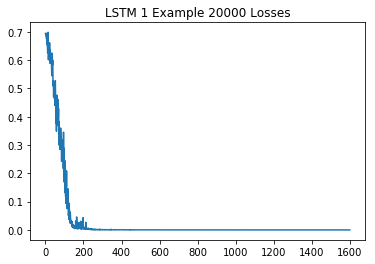

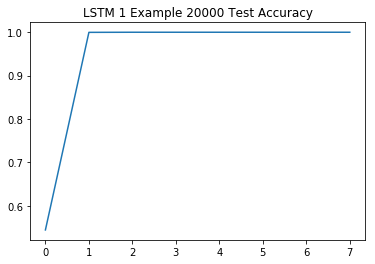

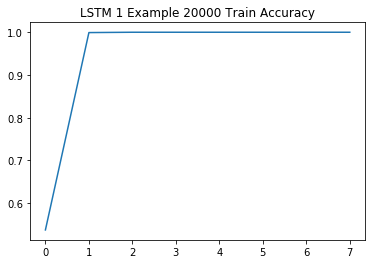

In [21]:
## plots
plt.plot(np.arange(len(losses)), losses)
plt.title('LSTM 1 Example 20000 Losses')
plt.savefig("plots/lstm_1example_20000c_losses_attn.png")
plt.show()

plt.plot(np.arange(len(accs)), accs)
plt.title('LSTM 1 Example 20000 Test Accuracy')
plt.savefig("plots/lstm_1example_20000c_test_acc_attn.png")
plt.show()

plt.plot(np.arange(len(accs_tr)), accs_tr)
plt.title('LSTM 1 Example 20000 Train Accuracy')
plt.savefig("plots/lstm_1example_20000c_train_acc_attn.png")
plt.show()

In [22]:
with open('models/lstm_1example_20000c_attn.tar','wb') as ckpt:
     torch.save(rnn, ckpt)

/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Analysis and Diagnostic Classifier

In [88]:
from sklearn import metrics
from scipy import stats
import scipy as sp

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from scipy.stats import pearsonr

import seaborn as sns

In [18]:
rnn = torch.load('models/lstm_1example_20000c.tar').cuda()

In [83]:
def hypothesis_k_factors(text):
    return np.array([-1 if x == '#' or x == '$' else 1 for x in text])

def hypothesis_detect_k_factors(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
    return hyp

def hypothesis_match_grammar(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
            for i, j in zip(range(len(kf)), reversed(range(len(kf)))):
                if j != 0:
                    ind = [m.start() for m in re.finditer(kf[:-j], text)]
                    print(ind, kf[:-j], i)
                    for el in ind:
                        hyp[el:el+i] = 1
    return hyp

In [67]:
hypothesis_match_grammar("bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb")

[8, 9, 12, 24, 28] c 0
[12, 28] cd 1


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])

In [84]:
def validate_hypothesis(model, diag_classifier, hypothesis, train_len=50,
                        test_len=1, tt=None, save_hyp=None, save_diag=None, save_resp=None):
    # Generate hypothesis data
    def gen_hyp_data(model, N, hypothesis, start_index):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        inp, target = generate_random_batch(len_example, N, inps, labels)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(inp[i])):
                _, hidden, cell = rnn(inp[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(inps[i])
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(inps[i])
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)
    
    def gen_hyp_data_test(model, N, hypothesis, tt):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        tensor_tt = convert_string(tt)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(tensor_tt[i])):
                _, hidden, cell = rnn(tensor_tt[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(tt)
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(tt)
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)

    # Generate train and test data
    _, train_hyps, train_hiddens, train_hiddens_2 = gen_hyp_data(model, train_len, hypothesis, 0)
    test_texts, test_hyps, test_hiddens, test_hiddens_2 = gen_hyp_data_test(model, test_len, hypothesis, tt)
    #print(pearsonr(train_hiddens, train_hyps))
    #print(pearsonr(test_hiddens, test_hyps))

    # Train Diagnostic Classifier
    diag_classifier.fit(train_hiddens, train_hyps)
    
    # Predict with Diagnostic Classifier
    pred_hyps = diag_classifier.predict(test_hiddens)
    
    # Find responsible neuron
    resp_neuron = np.argmax(np.abs(diag_classifier.coef_))
    print(resp_neuron)
    
    # Plot results
    if save_hyp:
        plot_colored_text(test_texts[:len_example], test_hyps[:len_example],
                          title='Formed Hypothesis',
                          save_file=save_hyp)
    if save_diag:
        plot_colored_text(test_texts[:len_example], pred_hyps[:len_example],
                          title='Diagnostic Classifier Prediction',
                          save_file=save_diag)
    if save_resp:
        plot_colored_text(test_texts[:len_example], test_hiddens[:len_example, resp_neuron],
                          title='Most Responsible Neuron {}'.format(resp_neuron),
                          save_file=save_resp)
        
    del(train_hyps)
    del(train_hiddens)
    del(test_texts)
    del(test_hiddens)
    gc.collect()
    
    return test_hyps, pred_hyps

In [85]:
### PLOTTING HELPERS ###
def wrap_colored_text(text, colors, W, tabsize=4):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []

    # Wrap lines to width
    for char, color in zip(text, colors):
        if char == '\t':
            for i in range(tabsize):
                new_text.append(' ')
                new_colors.append(color)
        else:
            new_text.append(char)
            new_colors.append(color)
            if char == '\n':
                for i in range(W - len(new_text) % W):
                    new_text.append(' ')
                    new_colors.append(np.zeros_like(colors[0]))

    # Add final space to obtain (rectangular) matrix
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))

    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)

def plot_colored_text(text, colors, W=80, title=None, save_file=None):
    wrapped_text, wrapped_colors = wrap_colored_text(text, colors, W, tabsize=4)

    H = len(wrapped_text)
    plt.figure(figsize=(W/5, H/3))

    color_palette = sns.color_palette("RdBu_r", 255, desat=.9)
    color_palette[127] = (1.,1.,1.) # set zero to white color
    sns.heatmap(wrapped_colors, annot=wrapped_text,
                annot_kws={'color':'black',
                           'family':'monospace',
                           'horizontalalignment':'center',
                           'fontweight':'light'},
                fmt='s', cbar=False, vmin=-2, vmax=2)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save_file:
        plt.savefig(save_file)
    plt.show()

96


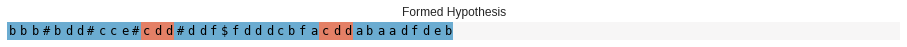

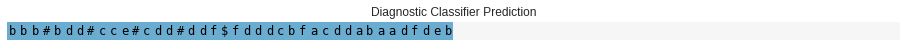

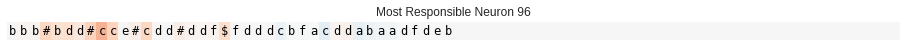

In [89]:
model_name = "lstm_5example_20000c_attn"
hyp_name = "detect_k_factors"
y_true, y_pred = validate_hypothesis(rnn, LogisticRegression(), hypothesis_detect_k_factors,
                                         train_len=1000, test_len=1, tt="bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb",
                                         save_hyp='plots/{}_hyp_{}.png'.format(model_name, hyp_name),
                                         save_diag='plots/{}_diag_{}.png'.format(model_name, hyp_name),
                                         save_resp='plots/{}_resp_{}.png'.format(model_name, hyp_name))